# Importing Libraries

In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import torch
from tqdm import tqdm
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reading Test Data

In [2]:
test_images = []
image_names = []
test_images_path = "Data/BCSS/train"
for i in os.listdir(test_images_path)[6000:8000]:
    image_names.append(i)
    img = cv2.imread(os.path.join(test_images_path, i))
    test_images.append(img)

test_images = np.array(test_images)

In [29]:
mask_images = []

mask_images_path = "Data/BCSS/train_mask"
for i in image_names:
    img = cv2.imread(os.path.join(mask_images_path, i))
    mask_images.append(img)

mask_images = np.array(mask_images)

# Loading Models 

## Importing Models

In [6]:
import torch
import torch.nn as nn
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self,input_channel = 3, out_channel = 3, filter_sizes = [32,64,128]):
        super(Unet,self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.softmax = nn.Softmax2d()

        #Encoder
        for i in filter_sizes:
            self.encoder.append(DoubleConv(input_channel,i))
            input_channel = i
        
        #Decoder
        for i in reversed(filter_sizes):
            self.decoder.append(nn.ConvTranspose2d(i*2,i,kernel_size=2,stride=2))
            self.decoder.append(DoubleConv(i*2,i))
       
        self.bottleneck = DoubleConv(filter_sizes[-1],filter_sizes[-1]*2)
        self.final_layer = nn.Conv2d(filter_sizes[0],out_channel,kernel_size=1)

    def forward(self,x):
        connections = []
        for enc in self.encoder:
            x = enc(x)
            connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        connections = connections[::-1]
        for index in range(0,len(self.decoder),2):
            x = self.decoder[index](x)
            connection = connections[index//2]
            if x.shape != connection.shape:
                x = nn.functional.interpolate(x,size = connection.shape[2:])
            concat_connection = torch.cat([connection,x],dim=1)
            x = self.decoder[index+1](concat_connection)
        
        x = self.final_layer(x)
        
        x  = self.softmax(x)
       
        return x
        #return nn.Softmax(dim=1)(x)
    
    def train(self,images,masks,val_images,val_masks,epochs,learning_rate,batch_size = 32):
        optimizer = torch.optim.Adam(self.parameters(),lr = learning_rate)
        criterion = nn.CrossEntropyLoss()
        epoch_loss = []
        epoch_val_loss = []
        for epoch in (range(epochs)):
            training_losses = []
            validation_losses = []

            for i in tqdm(range(0,len(images),batch_size)):
                optimizer.zero_grad()
                batch_images = torch.Tensor(images[i:i+batch_size]).permute(0,3,1,2).to(device)
                batch_masks = torch.Tensor(masks[i:i+batch_size]).permute(0,3,1,2).to(device)
                preds = self(batch_images)
                
                loss = criterion(preds,batch_masks)
                loss.backward()
                
                optimizer.step()
                training_losses.append(loss.item())
            
            for i in (range(0,len(val_images),batch_size)):
                optimizer.zero_grad()
                batch_images = torch.Tensor(val_images[i:i+batch_size]).permute(0,3,1,2).to(device)
                batch_masks = torch.Tensor(val_masks[i:i+batch_size]).permute(0,3,1,2).to(device)
                preds = self(batch_images)
                
                loss = criterion(preds,batch_masks)
                
                validation_losses.append(loss.item())

            epoch_loss.append(np.mean(training_losses))
            epoch_val_loss.append(np.mean(validation_losses))
            

            
            
            
            print(f"Epoch : {epoch+1}, Training Loss : {np.mean(training_losses)}, Validation Loss : {np.mean(validation_losses)}")
        #return training_losses,validation_losses
        

    def predict(self,input_img):
        input_img = torch.Tensor(input_img).permute(0,3,1,2).to(device)
        prediction = self(input_img).permute(0,2,3,1)
        
        return prediction.cpu().detach().numpy()

In [7]:
def load_model(weights_path = None,gpu=True):
    Pretrained_Unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
    Pretrained_Unet.conv = nn.Conv2d(32,3,kernel_size=1)
    
    if gpu:
        Pretrained_Unet = Pretrained_Unet.to(device)
    if weights_path:
        Pretrained_Unet.load_state_dict(torch.load(weights_path))
        
    return Pretrained_Unet

## Loading Weights

In [8]:
Custom_Augmented = Unet(3,3).to(device)
Custom_Augmented.load_state_dict(torch.load("ModelWeights/model_weights_180_Epoch.pth"))

Custom_NoAugmented = Unet(3,3).to(device)
Custom_NoAugmented.load_state_dict(torch.load("ModelWeights/model_weights_nonaugment50Epoch.pth"))

Pretrained_Augmented = load_model("ModelWeights/Pretrained_Unet_55_Epoch.pth")
Pretrained_NoAugmented = load_model("ModelWeights/Pretrained_Unet_nonaugment50Epoch.pth")

Using cache found in C:\Users\burak/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\burak/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


# Helper Functions

#### Since objective is multi-label, binary masks for each class is needed to calculate class-based scores.

In [11]:
def prediction_To_mask(pred,class_Num): 

    masks = []
    for img in pred:
        
    
        mask = np.zeros((img.shape[0],img.shape[1],class_Num),dtype=int)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                mask[i,j,:] = np.argmax(img[i,j,:])
        masks.append(mask)
    return masks

def Binary_Masks_Prediction(mask,class_num):
    # returns binary masks for each class
    binary_masks = [np.zeros((mask.shape[0],mask.shape[1])) for i in range(class_num)]
    for i in range((mask.shape[0])):
        for j in range((mask.shape[1])):
            class_ind = np.argmax(mask[i,j,:])
            binary_masks[class_ind][i,j] = 1
    return binary_masks # class_num x height x width

def Binary_Masks_GT(mask,class_num):
    # returns binary masks for each class
    binary_masks = [np.zeros((mask.shape[0],mask.shape[1])) for i in range(class_num)]
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            class_ind = mask[i,j,0]
            
            binary_masks[class_ind][i,j] = 1

    return binary_masks  # class_num x height x width

# Test Evaluation

## Storing Predictions

In [7]:
predictions_custom_aug = []
predictions_custom_Naug = []
predictions_pretrained_aug = []
predictions_pretrained_Naug = []

for i in tqdm(test_images):
    
    i = i/255.0
    i = i.reshape(1,224,224,3)
    i = torch.Tensor(i).to(device)
    predictions_custom_aug.append(Custom_Augmented.predict(i)[0])
    predictions_custom_Naug.append(Custom_NoAugmented.predict(i)[0])


    i = i.permute(0,3,1,2).to(device)
    prediction = Pretrained_Augmented(i).permute(0,2,3,1)
    prediction = prediction.cpu().detach().numpy()
    prediction = prediction[0]
    predictions_pretrained_aug.append(prediction)

    prediction = Pretrained_NoAugmented(i).permute(0,2,3,1)
    prediction = prediction.cpu().detach().numpy()
    prediction = prediction[0]
    predictions_pretrained_Naug.append(prediction)

predictions_custom_aug = np.array(predictions_custom_aug)
predictions_custom_Naug = np.array(predictions_custom_Naug)
predictions_pretrained_aug = np.array(predictions_pretrained_aug)
predictions_pretrained_Naug = np.array(predictions_pretrained_Naug)

100%|██████████| 2000/2000 [04:06<00:00,  8.11it/s]


# Score Evaluation

### Prediction Conversion

In [9]:
binary_masks_GT = []
for i in tqdm(mask_images):
    binary_masks_GT.append(Binary_Masks_GT(i,3))

binary_masks_GT = np.array(binary_masks_GT)

binary_masks_custom_aug = []
binary_masks_custom_Naug = []
binary_masks_pretrained_aug = []
binary_masks_pretrained_Naug = []

for i in tqdm(predictions_custom_aug):
    binary_masks_custom_aug.append(Binary_Masks_Prediction(i,3))

for i in tqdm(predictions_custom_Naug):
    binary_masks_custom_Naug.append(Binary_Masks_Prediction(i,3))

for i in tqdm(predictions_pretrained_aug):
    binary_masks_pretrained_aug.append(Binary_Masks_Prediction(i,3))

for i in tqdm(predictions_pretrained_Naug):
    binary_masks_pretrained_Naug.append(Binary_Masks_Prediction(i,3))

binary_masks_custom_aug = np.array(binary_masks_custom_aug)
binary_masks_custom_Naug = np.array(binary_masks_custom_Naug)
binary_masks_pretrained_aug = np.array(binary_masks_pretrained_aug)
binary_masks_pretrained_Naug = np.array(binary_masks_pretrained_Naug)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [03:18<00:00, 10.05it/s]


## Score Calculation

In [14]:


from sklearn.metrics import jaccard_score

def Jaccard_Score(gt,pred):
    scores = []
    for i in range(len(gt)):
        score = jaccard_score(gt[i].flatten(),pred[i].flatten())
        scores.append(score)
    return np.array(scores).mean()

Jaccard_custom_aug_0  = Jaccard_Score(binary_masks_GT[:,0],binary_masks_custom_aug[:,0])
Jaccard_custom_aug_1  = Jaccard_Score(binary_masks_GT[:,1],binary_masks_custom_aug[:,1])
Jaccard_custom_aug_2  = Jaccard_Score(binary_masks_GT[:,2],binary_masks_custom_aug[:,2])

Jaccard_custom_Naug_0  = Jaccard_Score(binary_masks_GT[:,0],binary_masks_custom_Naug[:,0])
Jaccard_custom_Naug_1  = Jaccard_Score(binary_masks_GT[:,1],binary_masks_custom_Naug[:,1])
Jaccard_custom_Naug_2  = Jaccard_Score(binary_masks_GT[:,2],binary_masks_custom_Naug[:,2])

Jaccard_pretrained_aug_0  = Jaccard_Score(binary_masks_GT[:,0],binary_masks_pretrained_aug[:,0])
Jaccard_pretrained_aug_1  = Jaccard_Score(binary_masks_GT[:,1],binary_masks_pretrained_aug[:,1])
Jaccard_pretrained_aug_2  = Jaccard_Score(binary_masks_GT[:,2],binary_masks_pretrained_aug[:,2])

Jaccard_pretrained_Naug_0  = Jaccard_Score(binary_masks_GT[:,0],binary_masks_pretrained_Naug[:,0])
Jaccard_pretrained_Naug_1  = Jaccard_Score(binary_masks_GT[:,1],binary_masks_pretrained_Naug[:,1])
Jaccard_pretrained_Naug_2  = Jaccard_Score(binary_masks_GT[:,2],binary_masks_pretrained_Naug[:,2])

In [15]:
print("Jaccard Score for Custom Augmented Model")
print(f"Class 0 : {Jaccard_custom_aug_0}")
print(f"Class 1 : {Jaccard_custom_aug_1}")
print(f"Class 2 : {Jaccard_custom_aug_2}")

print("Jaccard Score for Custom Non Augmented Model")
print(f"Class 0 : {Jaccard_custom_Naug_0}")
print(f"Class 1 : {Jaccard_custom_Naug_1}")
print(f"Class 2 : {Jaccard_custom_Naug_2}")

print("Jaccard Score for Pretrained Augmented Model")
print(f"Class 0 : {Jaccard_pretrained_aug_0}")
print(f"Class 1 : {Jaccard_pretrained_aug_1}")
print(f"Class 2 : {Jaccard_pretrained_aug_2}")

print("Jaccard Score for Pretrained Non Augmented Model")
print(f"Class 0 : {Jaccard_pretrained_Naug_0}")
print(f"Class 1 : {Jaccard_pretrained_Naug_1}")
print(f"Class 2 : {Jaccard_pretrained_Naug_2}")



Jaccard Score for Custom Augmented Model
Class 0 : 0.10545137706420024
Class 1 : 0.30707611439035126
Class 2 : 0.15479480658566128
Jaccard Score for Custom Non Augmented Model
Class 0 : 0.07539155728928756
Class 1 : 0.37082118570127137
Class 2 : 0.25610647928213176
Jaccard Score for Pretrained Augmented Model
Class 0 : 0.07471843654104922
Class 1 : 0.2897412953098452
Class 2 : 0.259490380749659
Jaccard Score for Pretrained Non Augmented Model
Class 0 : 0.0848004311983536
Class 1 : 0.3538101804801676
Class 2 : 0.23686941459071892


# Visualization of Scores

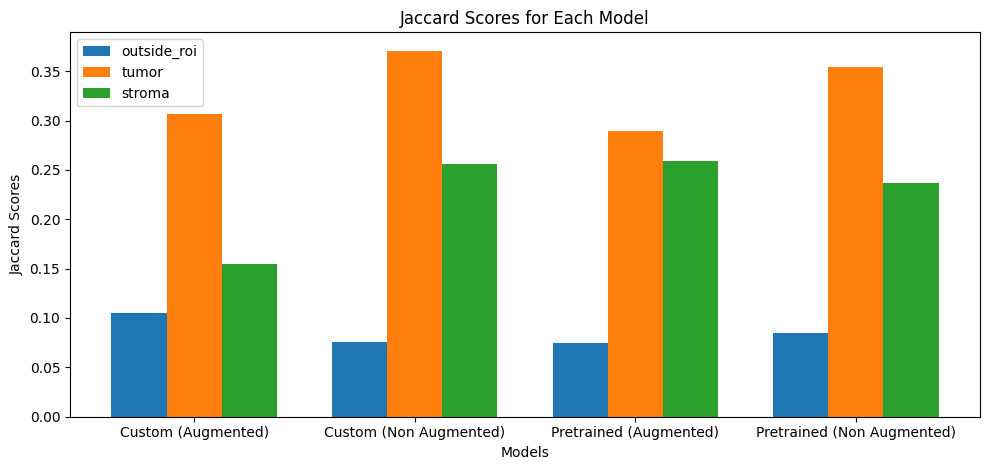

In [22]:
class_0_scores = [Jaccard_custom_aug_0,Jaccard_custom_Naug_0,Jaccard_pretrained_aug_0,Jaccard_pretrained_Naug_0]
class_1_scores = [Jaccard_custom_aug_1,Jaccard_custom_Naug_1,Jaccard_pretrained_aug_1,Jaccard_pretrained_Naug_1]
class_2_scores = [Jaccard_custom_aug_2,Jaccard_custom_Naug_2,Jaccard_pretrained_aug_2,Jaccard_pretrained_Naug_2]
fig, ax = plt.subplots()

fig.set_figwidth(10)
bar_width = 0.25
index = np.arange(4)
opacity = 0.8
rects1 = plt.bar(index, class_0_scores, bar_width)
rects2 = plt.bar(index + bar_width, class_1_scores, bar_width)
rects3 = plt.bar(index + 2*bar_width, class_2_scores, bar_width)
plt.xlabel('Models')
plt.ylabel('Jaccard Scores')
plt.title('Jaccard Scores for Each Model')
plt.xticks(index + bar_width, ('Custom (Augmented)', 'Custom (Non Augmented)', 'Pretrained (Augmented)', 'Pretrained (Non Augmented)'))
plt.legend((rects1[0], rects2[0],rects3[0]), ('outside_roi', 'tumor','stroma'))
plt.tight_layout()
plt.show()

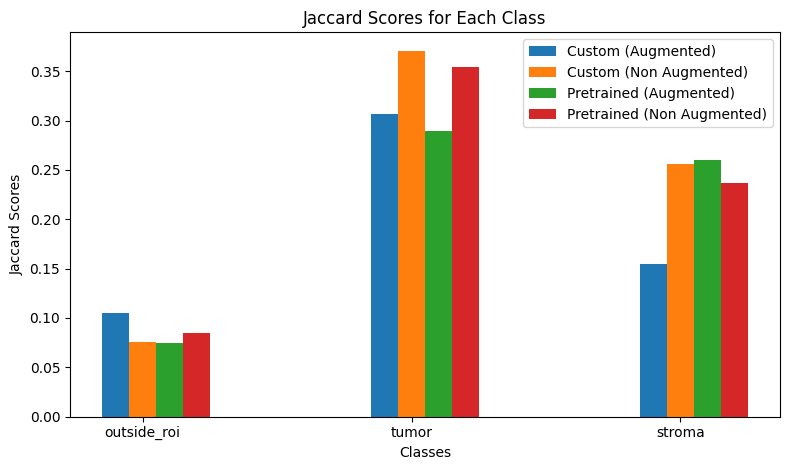

In [25]:
# I want to see classes in x axis and models in y axis

class_0_scores = [Jaccard_custom_aug_0,Jaccard_custom_Naug_0,Jaccard_pretrained_aug_0,Jaccard_pretrained_Naug_0]
class_1_scores = [Jaccard_custom_aug_1,Jaccard_custom_Naug_1,Jaccard_pretrained_aug_1,Jaccard_pretrained_Naug_1]
class_2_scores = [Jaccard_custom_aug_2,Jaccard_custom_Naug_2,Jaccard_pretrained_aug_2,Jaccard_pretrained_Naug_2]

fig, ax = plt.subplots()
fig.set_figwidth(8)
bar_width = 0.1
index = np.arange(3)
opacity = 0.8
rects1 = plt.bar(index, [class_0_scores[0],class_1_scores[0],class_2_scores[0],], bar_width)
rects2 = plt.bar(index + bar_width, [class_0_scores[1],class_1_scores[1],class_2_scores[1],], bar_width)
rects3 = plt.bar(index + 2*bar_width, [class_0_scores[2],class_1_scores[2],class_2_scores[2],], bar_width)
rects4 = plt.bar(index + 3*bar_width, [class_0_scores[3],class_1_scores[3],class_2_scores[3],], bar_width)
plt.xlabel('Classes')
plt.ylabel('Jaccard Scores')
plt.title('Jaccard Scores for Each Class')
plt.xticks(index + bar_width, ('outside_roi', 'tumor', 'stroma'))
plt.legend((rects1[0], rects2[0],rects3[0],rects4[0]), ('Custom (Augmented)', 'Custom (Non Augmented)', 'Pretrained (Augmented)', 'Pretrained (Non Augmented)'))
plt.tight_layout()
plt.show()



# Visualization of Predictions

In [54]:
def prediction_To_mask(pred,class_Num): 

    masks = []
    for img in pred:
        mask = np.zeros((img.shape[0],img.shape[1],class_Num),dtype=int)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                mask[i,j,:] = np.argmax(img[i,j,:])
        masks.append(mask)
    return masks


def convert_mask_to_RGB(mask_Exp):
    for i in range(len(mask_Exp)):
        for j in range(len(mask_Exp)):
            if mask_Exp[i][j][0] ==  0 : 
                mask_Exp[i][j] =  [255,0,0] 
            elif mask_Exp[i][j][0] == 1:
                mask_Exp[i][j] = [0,255,0]
            elif mask_Exp[i][j][0] == 2:
                mask_Exp[i][j] = [0,0,255]
    return mask_Exp



def PlotPredictions(images,mask_images,prediction_masks,class_dict):
    fig,axs = plt.subplots(len(images),6,figsize=(30,len(images) * 3))
    
    axs[0,0].set_title("Original Image")
    axs[0,1].set_title("Ground Truth Mask")
    axs[0,2].set_title("Predicted Mask (Custom Augmented)")
    axs[0,3].set_title("Predicted Mask (Custom Non Augmented)")
    axs[0,4].set_title("Predicted Mask (Pretrained Augmented)")
    axs[0,5].set_title("Predicted Mask (Pretrained Non Augmented)")


    for i in range(len(images)):
        axs[i,0].imshow(images[i])
        mask_images[i] = convert_mask_to_RGB(mask_images[i])
        axs[i,1].imshow(mask_images[i])

        prediction_masks[0][i] = convert_mask_to_RGB(prediction_masks[0][i])
        prediction_masks[1][i] = convert_mask_to_RGB(prediction_masks[1][i])
        prediction_masks[2][i] = convert_mask_to_RGB(prediction_masks[2][i])
        prediction_masks[3][i] = convert_mask_to_RGB(prediction_masks[3][i])

        axs[i,0].axis('off')
        axs[i,1].axis('off')
        axs[i,2].axis('off')
        axs[i,3].axis('off')
        axs[i,4].axis('off')
        axs[i,5].axis('off')

        axs[i,2].imshow(prediction_masks[0][i])
        axs[i,3].imshow(prediction_masks[1][i])
        axs[i,4].imshow(prediction_masks[2][i])
        axs[i,5].imshow(prediction_masks[3][i])
        
        patches = [mpatches.Patch(color=class_dict[i]/255, label=i) for i in class_dict.keys()]

        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
    plt.show()

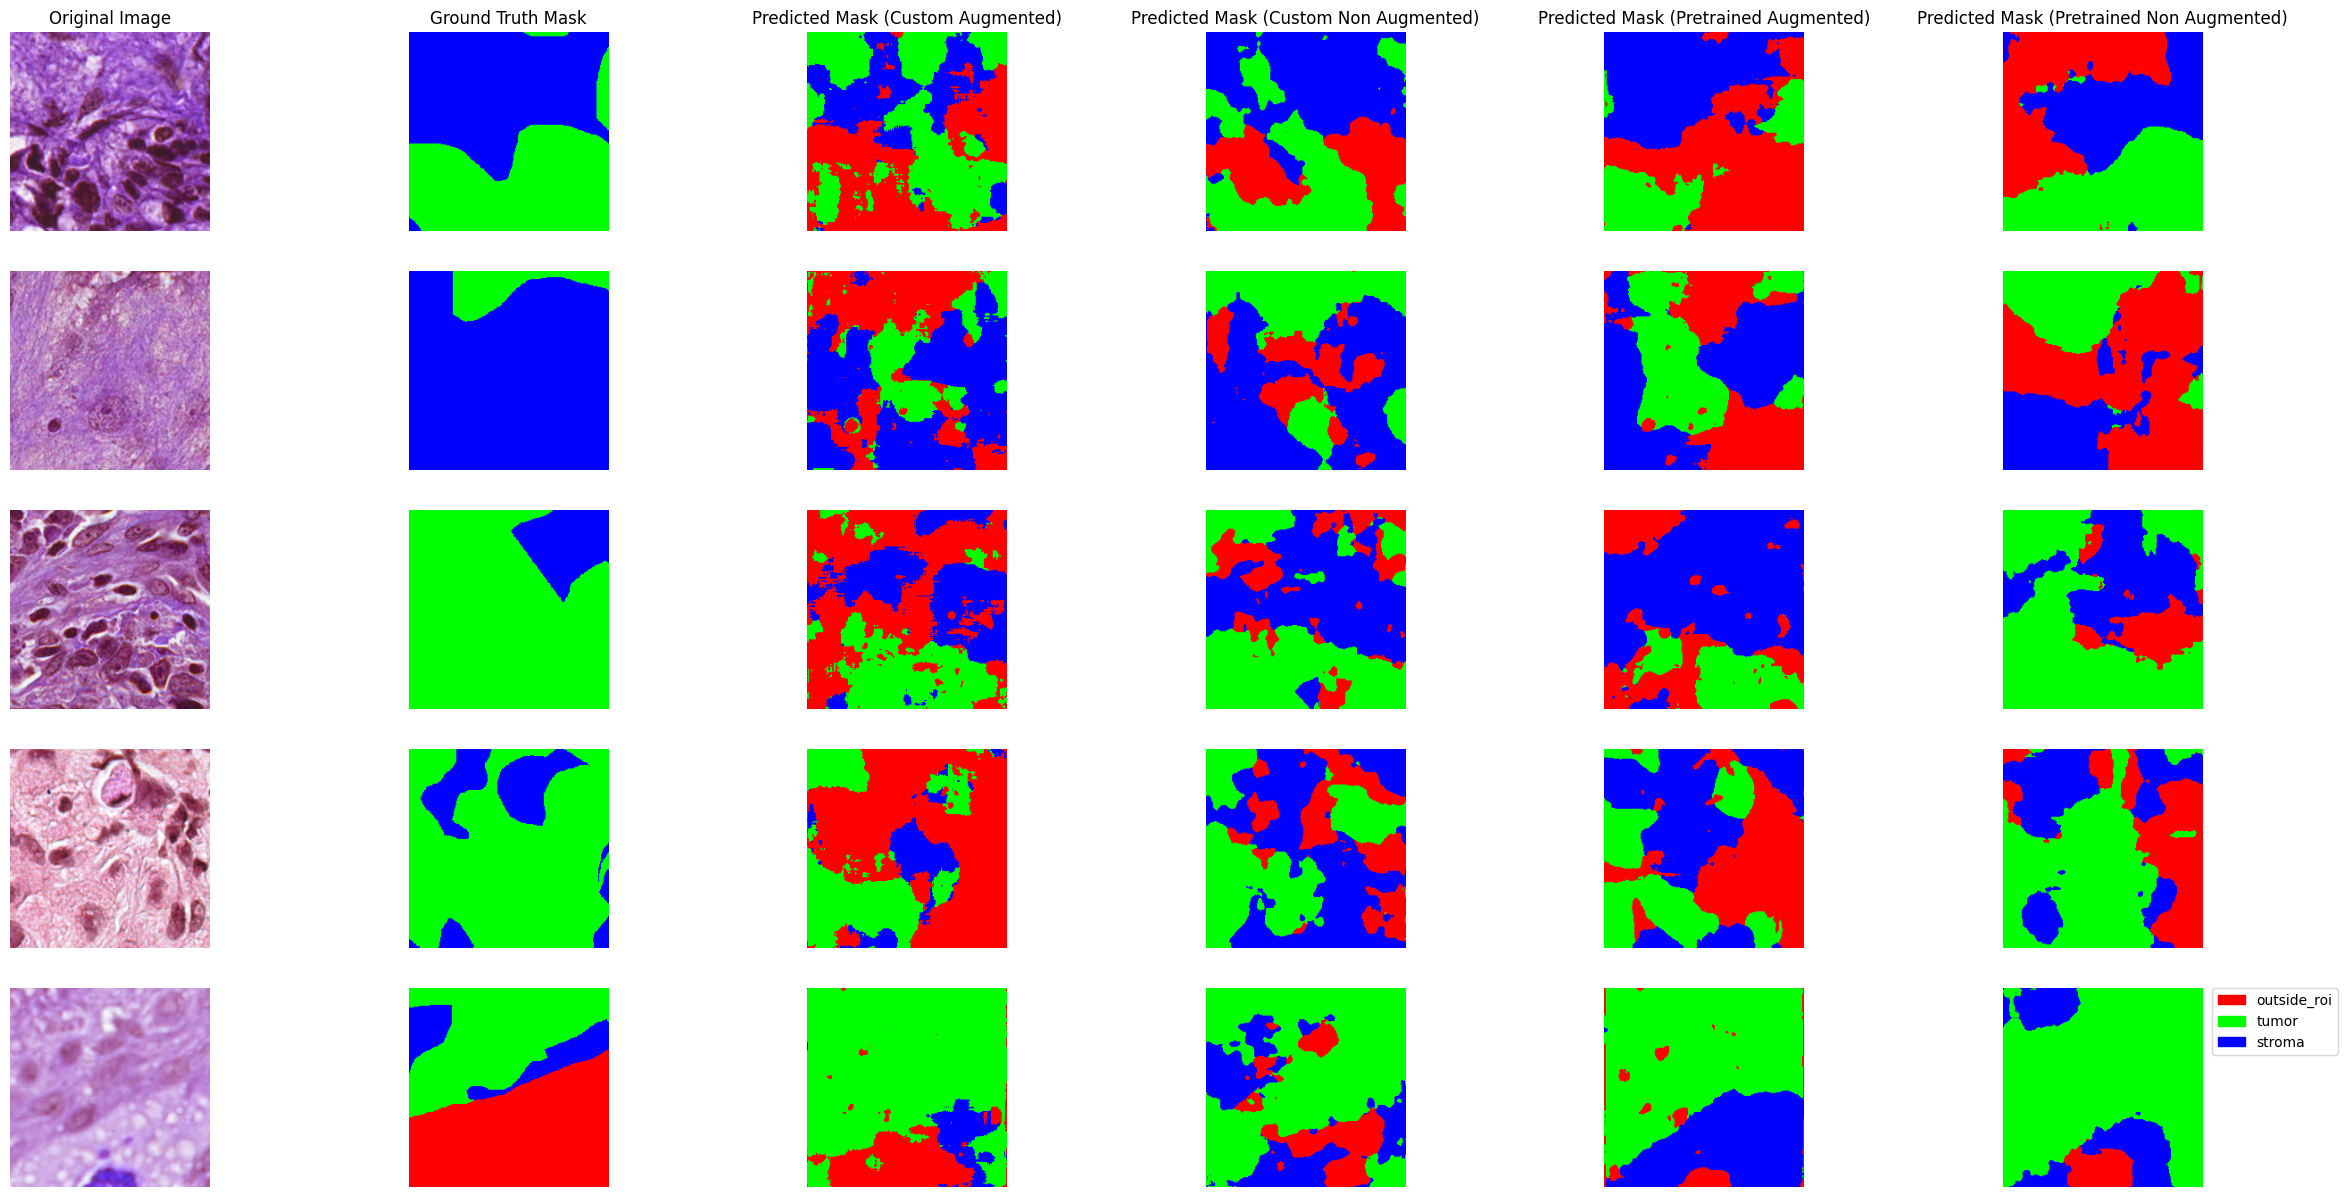

In [69]:
inds = np.random.randint(0,len(test_images),5)
images = test_images[inds]
mask_images_sample = mask_images[inds]
prediction_masks_caug = prediction_To_mask(predictions_custom_aug[inds],3)
prediction_masks_cnaug = prediction_To_mask(predictions_custom_Naug[inds],3)
prediction_masks_paug = prediction_To_mask(predictions_pretrained_aug[inds],3)
prediction_masks_pnaug = prediction_To_mask(predictions_pretrained_Naug[inds],3)

predictions = [prediction_masks_caug,prediction_masks_cnaug,prediction_masks_paug,prediction_masks_pnaug]
class_dict = {"outside_roi":np.array([255,0,0]),"tumor":np.array([0,255,0]),"stroma":np.array([0,0,255])}

PlotPredictions(images,mask_images_sample,predictions,class_dict)
